<a href="https://colab.research.google.com/github/rayhanakrom/PKL/blob/master/BismillahCodinganSkripsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#Basics
import numpy as np
import pandas as pd
import json

#Utility
import urllib
import os
import shutil
import time
import glob
from PIL import Image

#Vizualization
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import cv2

#MODEL
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout, AveragePooling2D, Concatenate
from keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [30]:
  from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

ln: failed to create symbolic link '/mydrive/My Drive': File exists


In [32]:
!ls /mydrive/SKRIPSI/Dataset

annotations  gambar  images  mobilenetv2_1.0-0c6065bc.pth


In [33]:
for dirname, _, filenames in os.walk('/mydrive/SKRIPSI/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/mydrive/SKRIPSI/Dataset/mobilenetv2_1.0-0c6065bc.pth
/mydrive/SKRIPSI/Dataset/images/49401289163581ba.jpg
/mydrive/SKRIPSI/Dataset/images/4962738b2aa943d0.jpg
/mydrive/SKRIPSI/Dataset/images/49a30edbcde7b152.jpg
/mydrive/SKRIPSI/Dataset/images/49ad072f6bd4ee7b.jpg
/mydrive/SKRIPSI/Dataset/images/49c97b53010b9430.jpg
/mydrive/SKRIPSI/Dataset/images/49dfcc371d6e2812.jpg
/mydrive/SKRIPSI/Dataset/images/4a20c4d3dc4154c9.jpg
/mydrive/SKRIPSI/Dataset/images/4a3e69f3f9065c06.jpg
/mydrive/SKRIPSI/Dataset/images/4a4f468f2d7890de.jpg
/mydrive/SKRIPSI/Dataset/images/4a5d4ec6e77806f5.jpg
/mydrive/SKRIPSI/Dataset/images/4a8742b982437dd4.jpg
/mydrive/SKRIPSI/Dataset/images/4a907dd7abf4d097.jpg
/mydrive/SKRIPSI/Dataset/images/4a9ce83352343dae.jpg
/mydrive/SKRIPSI/Dataset/images/4a9d321766d832b4.jpg
/mydrive/SKRIPSI/Dataset/images/4b345f4079c58268.jpg
/mydrive/SKRIPSI/Dataset/images/4b3559ff61663719.jpg
/mydrive/SKRIPSI/Dataset/images/4b7a554158c6a556.jpg
/mydrive/SKRIPSI/Dataset/images/4bbfb56361b51

**SETUP DATASET**

In [34]:
IMAGE_SIZE = 224

In [35]:
img_dir = "/mydrive/SKRIPSI/Dataset/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

In [36]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [37]:
path = '/mydrive/SKRIPSI/Dataset/annotations'
text_files = ['/mydrive/SKRIPSI/Dataset/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [38]:
resizeannotation("/mydrive/SKRIPSI/Dataset/annotations/0a77fa2843b2f661.xml")

[144, 115, 118, 105]

In [39]:
y[0]

[223, 174, 220, 170]

In [40]:
np.array(X).shape

(1500, 224, 224, 3)

In [41]:
np.array(y).shape

(1500, 4)

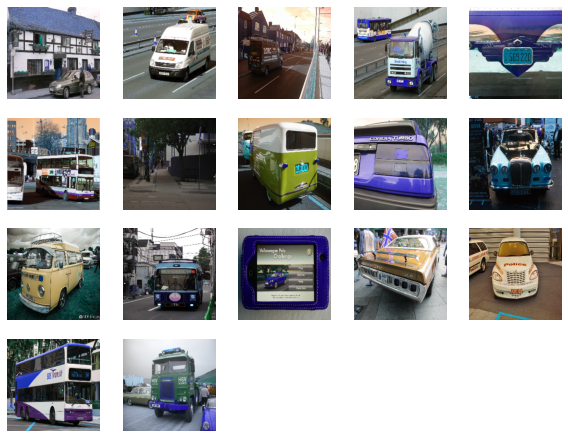

In [42]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

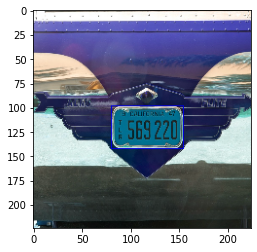

In [43]:
image = cv2.rectangle(X[4],(y[4][0],y[4][1]),(y[4][2],y[4][3]),(0, 0, 224))
plt.imshow(image)
plt.show()

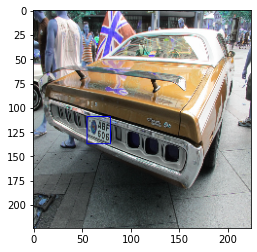

In [44]:
image = cv2.rectangle(X[13],(y[13][0],y[13][1]),(y[13][2],y[13][3]),(0, 0, 224))
plt.imshow(image)
plt.show()

In [45]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [46]:
#Renormalisation
X = X / 255
y = y / 255

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

**TRYING MODEL MOBILENETV2**

In [48]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.mobilenet_v2 import MobileNetV2


In [49]:
MNV2 = Sequential()

MNV2.add(MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
MNV2.add(Flatten())
MNV2.add(Dense(128, activation="relu"))
MNV2.add(Dense(64, activation="relu"))
MNV2.add(Dense(64, activation="relu"))
MNV2.add(Dense(32, activation="relu"))
MNV2.add(Dense(32, activation="relu"))
MNV2.add(Dense(16, activation="relu"))
MNV2.add(Dense(4, activation="sigmoid"))

net.layers[-7].trainable = False

input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3)
net.build(input_shape)

net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [50]:
MNV2.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

In [51]:
train = MNV2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16, verbose=1)

Epoch 1/50
68/68 [==============================] - 20s 212ms/step - loss: 0.0378 - accuracy: 0.4324 - val_loss: 0.0863 - val_accuracy: 0.5750
Epoch 2/50
68/68 [==============================] - 13s 196ms/step - loss: 0.0226 - accuracy: 0.5713 - val_loss: 0.0740 - val_accuracy: 0.6750
Epoch 3/50
68/68 [==============================] - 13s 196ms/step - loss: 0.0135 - accuracy: 0.6843 - val_loss: 0.0870 - val_accuracy: 0.7250
Epoch 4/50
68/68 [==============================] - 14s 201ms/step - loss: 0.0122 - accuracy: 0.6750 - val_loss: 0.0509 - val_accuracy: 0.6167
Epoch 5/50
68/68 [==============================] - 14s 201ms/step - loss: 0.0088 - accuracy: 0.7556 - val_loss: 0.0458 - val_accuracy: 0.7333
Epoch 6/50
68/68 [==============================] - 13s 197ms/step - loss: 0.0074 - accuracy: 0.7935 - val_loss: 0.0445 - val_accuracy: 0.7083
Epoch 7/50
68/68 [==============================] - 13s 196ms/step - loss: 0.0052 - accuracy: 0.8046 - val_loss: 0.0423 - val_accuracy: 0.7083

In [52]:
MNV2.save('my_model.h7', overwrite=True) 

INFO:tensorflow:Assets written to: my_model.h7/assets


INFO:tensorflow:Assets written to: my_model.h7/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [53]:
# Test
scores = MNV2.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 83.00%


In [54]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

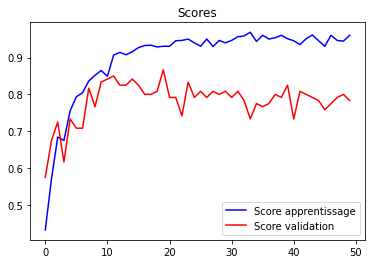

In [55]:
plot_scores(train)

In [57]:
test_loss, test_accuracy = MNV2.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

100/100 [==============================] - 3s 16ms/step - loss: 0.0160 - accuracy: 0.8300
Test results 
 Loss: 0.01604625955224037 
 Accuracy 0.8299999833106995


In [58]:
 y_cnn = MNV2.predict(X_test)

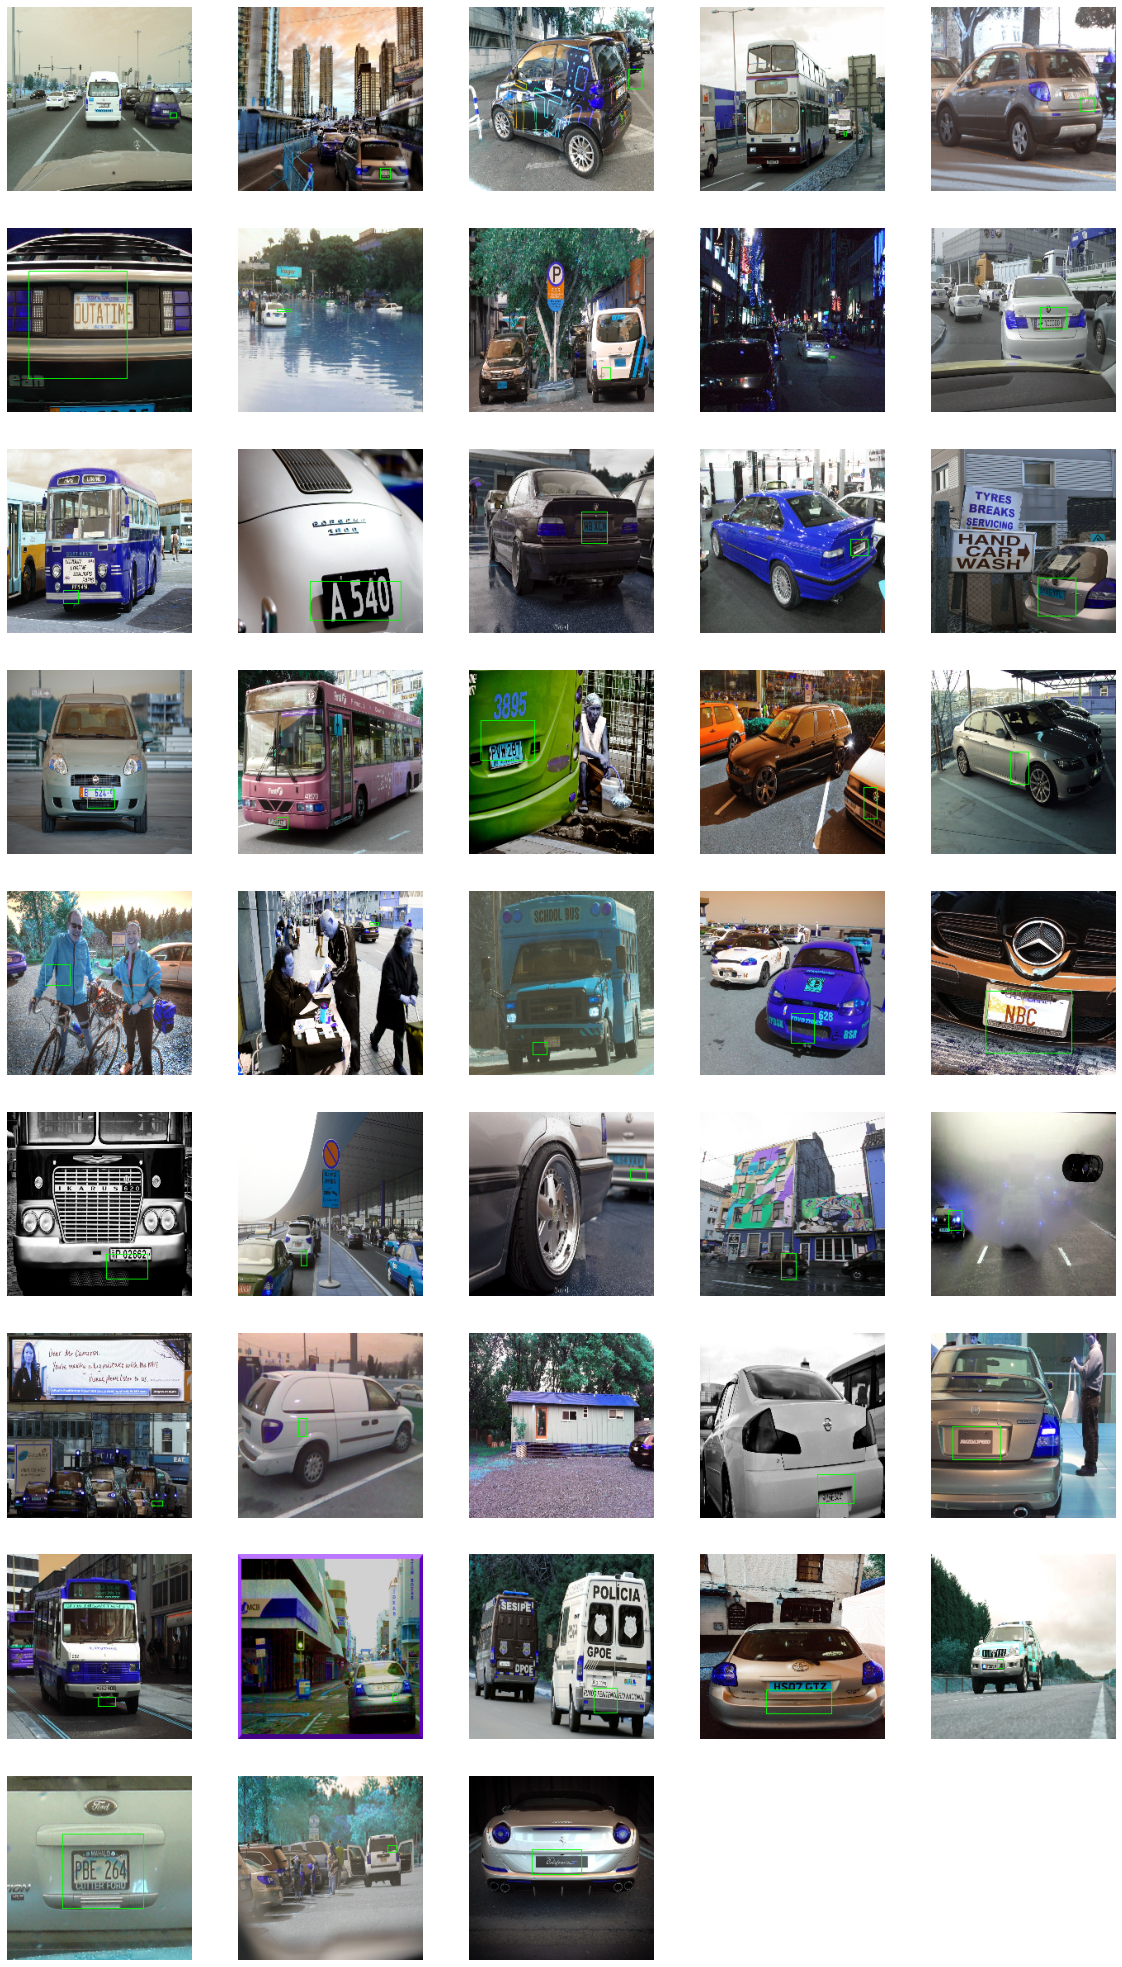

In [59]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)